![Py4Eng](img/logo.png)

# Convolutional Neural Networks with Keras
## Yoav Ram

In this session we will understand:
- how to use Keras as a high-level neural networks library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


Keras 2.2.4
GPU: []


# Multilayer Convolutional Network

We build a multilayer convolutional neuron network.

In a convolutional neural network we replace some of the fully-connected layers with convolutional layers in which we apply several convolutional filters to the input.

See this [animation of convolutions](http://cs231n.github.io/assets/conv-demo/index.html).

A convolution is very efficient because parameters of the convolution are shared among all pixels, and the convolution is robust to the position of a feature inside the image.

We'll start by implementing a two-layer network in which the first layer is a convolutional layer and the second layer is a fully-connected softmax layer:
$$
\mathbf{Z_1} = \mathbf{X_1} \ast \mathbf{W_1} + b_1 \\
\mathbf{X_2} = pool({\tanh{(\mathbf{Z_1})}}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} + b_2 \\
\mathbf{\widehat Y} = softmax(\mathbf{Z_2})
$$

![](http://deeplearning.net/tutorial/_images/mylenet.png)

# Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

We'll use the Keras that is installed with TensorFlow; for a more updated version we could install with `conda install -c conda-forge keras` or `pip install keras`.

## Get the data

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [3]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

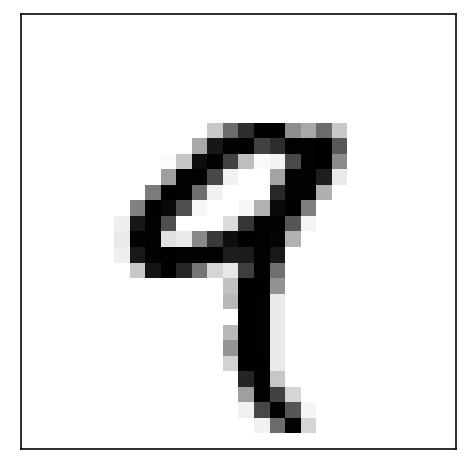

In [4]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[4])

## Keras model

We start by creating a Keras model, the neural network, to which we will add the different layers.
This model is a `Sequential` model, that is, data flows sequentially from one layer to the next.

In [16]:
model = keras.models.Sequential()

## Input layer

In the CNN model our data (the layers) is no longer 2D (`(nsamples, nfeatures)`).
It is now a 4D tensor with shape `(nsamples, width, height, nchannels)`, where `nchannels` can be, for example, 3 for a color image, or 10 for the output of 10 filters.

Note that the first layer in any model must have the `input_shape` parameter that defines the shape of a single input sample. 
Other layers can infer their shape from the previous layers (sequential model!)

The data arrives with just `(nsamples, width, height)` so we have to reshape it to `(nsamples, width, height, 1)` for a single channel (greyscale).

In [17]:
model.add(
    keras.layers.Reshape(target_shape=(width, height, 1), 
                         input_shape=(width, height)))

## First convolutional layer

The first convolutional layer is generated by a convolution with 1 input channel, 32 output channgels, and 5x5 kernels.

The convolution computes 32 features of 5x5 patches; it returns a tensor with shape `(-1, 28, 28, 32)`.

See this [animation of convolutions](http://cs231n.github.io/assets/conv-demo/index.html).

We then apply a ReLu activation function ($f(x)=max(0,x)$).

In [18]:
model.add(
    keras.layers.Conv2D(32, (5, 5), activation='relu'))

## Pooling

The new element here is the $pool$ function, which applies **pooling** - the combination of several neurons/pixels into a single one.

We will use a common pooling approach called *2x2 max pooling* in which every 2x2 square of pixels is replaced by its maximal value.

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

Pooling adds another non-linear component, reduces the size of the layers, and thus the number of paramters, and reduces over-fitting by approximating the location of feautures.

Since thd activation function operates element-wise without impacting the shape, the output of the activation and pooling has shape `(-1, 14, 14, 32)`.

In [19]:
model.add(
    keras.layers.MaxPool2D())

## Second convolutional layer

We add another convolution + pooling layer, the 2nd layer will have 64 features. The input has 32 channels (from the previous 32 features) but he data arrays are smaller (14x14) due to the previous pooling:

In [20]:
model.add(
    keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(
    keras.layers.MaxPool2D())

The data is now is shape `(-1, 7, 7, 64)`.

## Fully connected layer

Now we add a fully-connected layer with 1024 neurons. This is done by matrix multiplication with a 7x7x64-by-1024 weight matrix, just like we did with FFN.

But first we need to flatten the input from 7x7x64 to 3136.

In [21]:
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024, activation='relu'))

## Dropout layer

We apply a dropout to reduce overfitting: the dropout stochasticly removes neurons (outputs of the previous layer) and automatically scales the neurons it retained so that their expected sum remains unchanged.

In [22]:
model.add(
    keras.layers.Dropout(0.5))

## Readout layer

We add a Softmax regression layer, similar to the previous, simpler example, by adding a dense layer with softmax activation.

In [23]:
model.add(
    keras.layers.Dense(ncats, activation='softmax'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
__________

## Training

To train the model we need to define the loss function. We'll use the same cross entropy function as before. We also use the same measure for accuracy - we predict the most likelihood class and check that it is the correct label.

We use the [Adam optimizer](http://arxiv.org/pdf/1412.6980.pdf), an algorithm for stochastic gradient descent based on adaptive estimates of first and second moments.

In [28]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

The actual training takes about 6-7 mins on a MacBook Pro 13" 2016 with max specs, or about 1 min on AWS g3.4xlarge virtual machine with Tesla M60 GPU, reaching accuracy >99% on the validation set.

In [14]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1323 - acc: 0.9584 - val_loss: 0.0458 - val_acc: 0.9844
Epoch 2/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0450 - acc: 0.9861 - val_loss: 0.0325 - val_acc: 0.9893
Epoch 3/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0242 - val_acc: 0.9916
Epoch 4/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0246 - val_acc: 0.9914
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0281 - val_acc: 0.9920


Interestingly, the neural network very quickly achieves a better accuracy than the previous approach - after one epoch the validation accuracy is > 0.98.
The validation accuracy then fluctuates for a long time around 0.99.

Save the model and the history:

In [32]:
model.save('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

Load model and history:

In [33]:
model = keras.models.load_model('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "rb") as f:
    history = pickle.load(f)

Plot history:

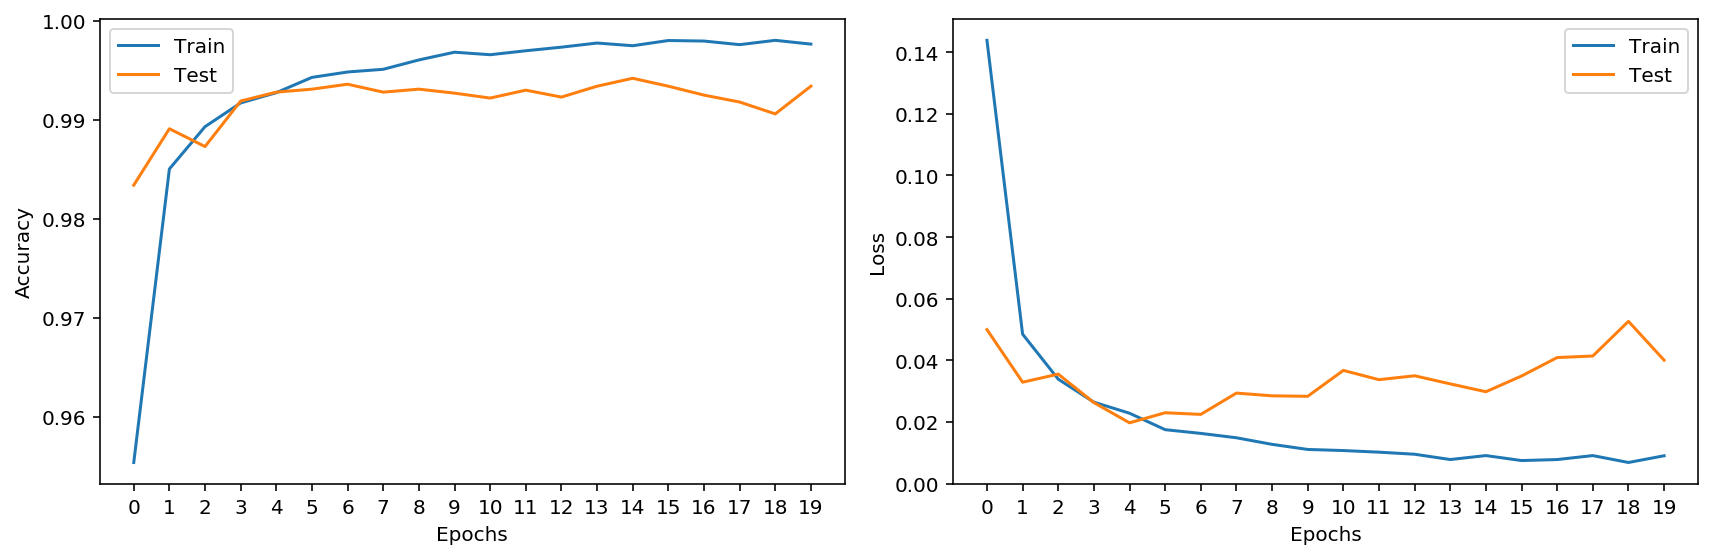

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax = axes[0]
ax.plot(history['acc'], label='Train')
ax.plot(history['val_acc'], label='Test')
ax.set(
    ylabel='Accuracy',
    xlabel='Epochs',
    xticks=np.arange(0, len(history['acc']))
)
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='Train')
ax.plot(history['val_loss'], label='Test')
ax.set(
    ylabel='Loss',
    xlabel='Epochs',
    xticks=np.arange(0, len(history['loss']))
)
ax.legend()
fig.tight_layout()

We can also visualize the network weights using [Quiver](https://keplr-io.github.io/quiver/).

# References

- Keras [examples](https://github.com/keras-team/keras/tree/master/examples)
- [Fashion-MNIST CNN exercise](../exercises/CNN.ipynb)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)